# 🔬 AI Detection of Heavy Metals in Agricultural Water
## Approche Hiérarchique : Classification Multi-niveaux (Cr & As)

**Architecture du système :**
```
                    Spectre SERS
                         │
                         ▼
              ┌─────────────────────┐
              │  MODÈLE 1 : Type    │
              │  (Control/Cr/As)    │
              └─────────────────────┘
                         │
          ┌──────────────┼──────────────┐
          ▼              ▼              ▼
       Control          Cr             As
       (Safe)           │              │
                        ▼              ▼
                   ┌─────────┐    ┌─────────┐
                   │MODÈLE 2a│    │MODÈLE 2b│
                   │Conc. Cr │    │Conc. As │
                   └─────────┘    └─────────┘
                        │              │
                        ▼              ▼
                   Concentration  Concentration
```

In [1]:
# Pour Google Colab uniquement
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.manifold import TSNE
from imblearn.over_sampling import SMOTE
from scipy.signal import savgol_filter
from scipy.sparse.linalg import spsolve
from scipy import sparse
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Set random seed for reproducibility
np.random.seed(42)

print("✓ Libraries imported successfully!")
print(f"Working directory: {os.getcwd()}")

✓ Libraries imported successfully!
Working directory: /content


---
# PARTIE 1 : Chargement et Préparation des Données
---

In [3]:
# ============================================================
# CONFIGURATION DES CHEMINS - MODIFIER SELON VOTRE ENVIRONNEMENT
# ============================================================

# Pour Google Colab:
cr_data_dir = Path(r'/content/drive/MyDrive/Cr')
as_data_dir = Path(r'/content/drive/MyDrive/AS')

# Pour local (décommenter si nécessaire):
# cr_data_dir = Path(r'c:\Users\Mossab Arektout\Desktop\tomo\Cr')
# as_data_dir = Path(r'c:\Users\Mossab Arektout\Desktop\tomo\AS')

# Paramètres
N_POINTS = 1011  # Nombre de points spectraux

print(f"Chrome (Cr) data directory: {cr_data_dir}")
print(f"Arsenic (As) data directory: {as_data_dir}")

Chrome (Cr) data directory: /content/drive/MyDrive/Cr
Arsenic (As) data directory: /content/drive/MyDrive/AS


In [4]:
# ============================================================
# DÉFINITION DES FICHIERS ET CONCENTRATIONS
# ============================================================

# Chrome (Cr) files
cr_files = [
    '00_Control.txt',
    '01_0.68 pM.txt',
    '02_6.8 pM.txt',
    '03_68 pM.txt',
    '04_0.68 nM.txt',
    '05_6.8 nM.txt',
    '06_68 nM.txt',
    '07_0.68 uM.txt',
    '08_6.8 uM.txt',
    '09_68 uM.txt'
]

cr_concentrations = [
    'Control', '0.68 pM', '6.8 pM', '68 pM', '0.68 nM',
    '6.8 nM', '68 nM', '0.68 µM', '6.8 µM', '68 µM'
]

# Arsenic (As) files
as_files = [
    '00_Control.txt',
    '01_5x10^-3 pM.txt',
    '02_5x10^-2 pM.txt',
    '03_5x10^-4 nM.txt',
    '04_5x10^-3 nM.txt',
    '05_0.05 nM.txt',
    '06_0.5 nM.txt',
    '07_5 nM.txt',
    '08_50 nM.txt',
    '09_0.5 uM.txt',
    '10_5 uM.txt',
    '11_50 uM.txt',
    '12_0.5 M.txt',
    '13_5 M.txt'
]

as_concentrations = [
    'Control', '5e-3 pM', '5e-2 pM', '5e-4 nM', '5e-3 nM',
    '0.05 nM', '0.5 nM', '5 nM', '50 nM', '0.5 µM',
    '5 µM', '50 µM', '0.5 M', '5 M'
]

print(f"Chrome: {len(cr_files)} fichiers ({len(cr_concentrations)} concentrations)")
print(f"Arsenic: {len(as_files)} fichiers ({len(as_concentrations)} concentrations)")

Chrome: 10 fichiers (10 concentrations)
Arsenic: 14 fichiers (14 concentrations)


In [5]:
# ============================================================
# FONCTION DE CHARGEMENT DES DONNÉES
# ============================================================

def load_sers_data_robust(filepath, n_points=1011, max_spectra=None):
    """
    Load SERS spectral data from text file with robust handling.
    """
    print(f"Loading: {Path(filepath).name}...", end=' ')

    valid_rows = []
    with open(filepath, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 4:
                try:
                    row = [float(parts[0]), float(parts[1]), float(parts[2]), float(parts[3])]
                    valid_rows.append(row)
                except ValueError:
                    continue

    data = np.array(valid_rows)
    wavenumbers_all = data[:, 2]
    intensities = data[:, 3]

    n_spectra = len(intensities) // n_points

    if max_spectra is not None and n_spectra > max_spectra:
        n_spectra = max_spectra

    spectra = intensities[:n_spectra * n_points].reshape(n_spectra, n_points)
    wavenumbers = wavenumbers_all[:n_points]

    print(f"✓ {n_spectra} spectra")
    return spectra, wavenumbers

print("Loading function defined.")

Loading function defined.


In [6]:
# ============================================================
# CHARGEMENT DE TOUTES LES DONNÉES (Cr + As)
# ============================================================

print("="*70)
print("CHARGEMENT DES DONNÉES CHROME (Cr)")
print("="*70)

X_cr_list = []
y_cr_type_list = []      # Type de métal (Control/Cr)
y_cr_conc_list = []      # Index de concentration
wavenumbers = None

for idx, (filename, conc_name) in enumerate(zip(cr_files, cr_concentrations)):
    filepath = cr_data_dir / filename
    max_spec = 4000 if idx == 0 else 1200  # Control: 4000, autres: 1200

    spectra, wn = load_sers_data_robust(filepath, n_points=N_POINTS, max_spectra=max_spec)

    if wavenumbers is None:
        wavenumbers = wn

    X_cr_list.append(spectra)

    # Labels
    if idx == 0:  # Control
        y_cr_type_list.extend(['Control'] * len(spectra))
    else:
        y_cr_type_list.extend(['Cr'] * len(spectra))

    y_cr_conc_list.extend([idx] * len(spectra))

X_cr = np.vstack(X_cr_list)
y_cr_type = np.array(y_cr_type_list)
y_cr_conc = np.array(y_cr_conc_list)

print(f"\nTotal Cr spectra: {X_cr.shape[0]}")

CHARGEMENT DES DONNÉES CHROME (Cr)
Loading: 00_Control.txt... ✓ 4000 spectra
Loading: 01_0.68 pM.txt... ✓ 1200 spectra
Loading: 02_6.8 pM.txt... ✓ 1200 spectra
Loading: 03_68 pM.txt... ✓ 1200 spectra
Loading: 04_0.68 nM.txt... ✓ 1200 spectra
Loading: 05_6.8 nM.txt... ✓ 1200 spectra
Loading: 06_68 nM.txt... ✓ 1200 spectra
Loading: 07_0.68 uM.txt... ✓ 1200 spectra
Loading: 08_6.8 uM.txt... ✓ 1200 spectra
Loading: 09_68 uM.txt... ✓ 1200 spectra

Total Cr spectra: 14800


In [7]:
print("\n" + "="*70)
print("CHARGEMENT DES DONNÉES ARSENIC (As)")
print("="*70)

X_as_list = []
y_as_type_list = []      # Type de métal (Control/As)
y_as_conc_list = []      # Index de concentration

for idx, (filename, conc_name) in enumerate(zip(as_files, as_concentrations)):
    filepath = as_data_dir / filename
    max_spec = 4000 if idx == 0 else 1200  # Control: 4000, autres: 1200

    spectra, wn = load_sers_data_robust(filepath, n_points=N_POINTS, max_spectra=max_spec)

    X_as_list.append(spectra)

    # Labels
    if idx == 0:  # Control
        y_as_type_list.extend(['Control'] * len(spectra))
    else:
        y_as_type_list.extend(['As'] * len(spectra))

    y_as_conc_list.extend([idx] * len(spectra))

X_as = np.vstack(X_as_list)
y_as_type = np.array(y_as_type_list)
y_as_conc = np.array(y_as_conc_list)

print(f"\nTotal As spectra: {X_as.shape[0]}")


CHARGEMENT DES DONNÉES ARSENIC (As)
Loading: 00_Control.txt... ✓ 4000 spectra
Loading: 01_5x10^-3 pM.txt... ✓ 1200 spectra
Loading: 02_5x10^-2 pM.txt... ✓ 1200 spectra
Loading: 03_5x10^-4 nM.txt... ✓ 1200 spectra
Loading: 04_5x10^-3 nM.txt... ✓ 1200 spectra
Loading: 05_0.05 nM.txt... ✓ 1200 spectra
Loading: 06_0.5 nM.txt... ✓ 1200 spectra
Loading: 07_5 nM.txt... ✓ 1200 spectra
Loading: 08_50 nM.txt... ✓ 1200 spectra
Loading: 09_0.5 uM.txt... ✓ 1200 spectra
Loading: 10_5 uM.txt... ✓ 1200 spectra
Loading: 11_50 uM.txt... ✓ 1200 spectra
Loading: 12_0.5 M.txt... ✓ 1200 spectra
Loading: 13_5 M.txt... ✓ 1200 spectra

Total As spectra: 19600


In [8]:
# ============================================================
# COMBINAISON DES DONNÉES POUR MODÈLE 1 (Type de métal)
# ============================================================

print("\n" + "="*70)
print("CRÉATION DU DATASET COMBINÉ POUR MODÈLE 1 (Type de métal)")
print("="*70)

# Pour le Modèle 1, on combine :
# - Control (de Cr uniquement pour éviter duplication)
# - Tous les Cr (sauf Control)
# - Tous les As (sauf Control)

# Séparer Control et non-Control pour Cr
mask_cr_control = y_cr_type == 'Control'
mask_cr_metal = y_cr_type == 'Cr'

X_control = X_cr[mask_cr_control]
y_control = np.array(['Control'] * len(X_control))

X_cr_only = X_cr[mask_cr_metal]
y_cr_only = np.array(['Cr'] * len(X_cr_only))

# Séparer non-Control pour As
mask_as_metal = y_as_type == 'As'
X_as_only = X_as[mask_as_metal]
y_as_only = np.array(['As'] * len(X_as_only))

# Combiner tout
X_combined = np.vstack([X_control, X_cr_only, X_as_only])
y_combined = np.concatenate([y_control, y_cr_only, y_as_only])

print(f"\nDataset combiné pour Modèle 1:")
print(f"  - Control: {len(X_control):,} spectra")
print(f"  - Chrome (Cr): {len(X_cr_only):,} spectra")
print(f"  - Arsenic (As): {len(X_as_only):,} spectra")
print(f"  - TOTAL: {len(X_combined):,} spectra")
print(f"\nShape: {X_combined.shape}")


CRÉATION DU DATASET COMBINÉ POUR MODÈLE 1 (Type de métal)

Dataset combiné pour Modèle 1:
  - Control: 4,000 spectra
  - Chrome (Cr): 10,800 spectra
  - Arsenic (As): 15,600 spectra
  - TOTAL: 30,400 spectra

Shape: (30400, 1011)


In [9]:
# ============================================================
# PRÉPARATION DES DONNÉES POUR MODÈLES 2a et 2b (Concentration)
# ============================================================

print("\n" + "="*70)
print("PRÉPARATION DES DATASETS POUR MODÈLES DE CONCENTRATION")
print("="*70)

# Dataset pour Modèle 2a (Concentration Cr) - SANS Control
X_cr_for_conc = X_cr[mask_cr_metal]
y_cr_for_conc = y_cr_conc[mask_cr_metal]  # Index 1-9 (pas 0 qui est Control)

# Dataset pour Modèle 2b (Concentration As) - SANS Control
X_as_for_conc = X_as[mask_as_metal]
y_as_for_conc = y_as_conc[mask_as_metal]  # Index 1-13 (pas 0 qui est Control)

print(f"\nDataset pour Modèle 2a (Concentration Cr):")
print(f"  - Spectra: {X_cr_for_conc.shape[0]:,}")
print(f"  - Classes: {len(np.unique(y_cr_for_conc))} concentrations")
print(f"  - Concentrations: {cr_concentrations[1:]}")

print(f"\nDataset pour Modèle 2b (Concentration As):")
print(f"  - Spectra: {X_as_for_conc.shape[0]:,}")
print(f"  - Classes: {len(np.unique(y_as_for_conc))} concentrations")
print(f"  - Concentrations: {as_concentrations[1:]}")


PRÉPARATION DES DATASETS POUR MODÈLES DE CONCENTRATION

Dataset pour Modèle 2a (Concentration Cr):
  - Spectra: 10,800
  - Classes: 9 concentrations
  - Concentrations: ['0.68 pM', '6.8 pM', '68 pM', '0.68 nM', '6.8 nM', '68 nM', '0.68 µM', '6.8 µM', '68 µM']

Dataset pour Modèle 2b (Concentration As):
  - Spectra: 15,600
  - Classes: 13 concentrations
  - Concentrations: ['5e-3 pM', '5e-2 pM', '5e-4 nM', '5e-3 nM', '0.05 nM', '0.5 nM', '5 nM', '50 nM', '0.5 µM', '5 µM', '50 µM', '0.5 M', '5 M']


---
# PARTIE 2 : Prétraitement des Données
---

In [10]:
# ============================================================
# FONCTIONS DE PRÉTRAITEMENT
# ============================================================

def baseline_als(y, lam=1e6, p=0.01, niter=10):
    """Asymmetric Least Squares baseline correction"""
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
    w = np.ones(L)
    for i in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

def preprocess_spectrum(spectrum, window_length=11, polyorder=3):
    """Preprocess a single SERS spectrum"""
    baseline = baseline_als(spectrum)
    corrected = spectrum - baseline
    smoothed = savgol_filter(corrected, window_length, polyorder)
    return smoothed

def preprocess_batch(X, batch_name=""):
    """Preprocess a batch of spectra with progress"""
    print(f"Preprocessing {batch_name} ({len(X):,} spectra)...")
    X_preprocessed = np.zeros_like(X)

    batch_size = 1000
    n_batches = int(np.ceil(len(X) / batch_size))

    for batch_idx in range(n_batches):
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, len(X))

        for i in range(start_idx, end_idx):
            X_preprocessed[i] = preprocess_spectrum(X[i])

        progress = (end_idx / len(X)) * 100
        print(f"  Progress: {progress:.1f}%", end='\r')

    print(f"  ✓ {batch_name} preprocessing complete!")
    return X_preprocessed

print("Preprocessing functions defined.")

Preprocessing functions defined.


In [11]:
# ============================================================
# PRÉTRAITEMENT DE TOUTES LES DONNÉES
# ============================================================

print("="*70)
print("PRÉTRAITEMENT DES DONNÉES")
print("="*70)

# Prétraiter le dataset combiné (pour Modèle 1)
X_combined_preprocessed = preprocess_batch(X_combined, "Combined Dataset")

# Prétraiter les datasets de concentration
X_cr_conc_preprocessed = preprocess_batch(X_cr_for_conc, "Cr Concentration Dataset")
X_as_conc_preprocessed = preprocess_batch(X_as_for_conc, "As Concentration Dataset")

print("\n✓ All preprocessing complete!")

PRÉTRAITEMENT DES DONNÉES
Preprocessing Combined Dataset (30,400 spectra)...
  ✓ Combined Dataset preprocessing complete!
Preprocessing Cr Concentration Dataset (10,800 spectra)...
  ✓ Cr Concentration Dataset preprocessing complete!
Preprocessing As Concentration Dataset (15,600 spectra)...
  ✓ As Concentration Dataset preprocessing complete!

✓ All preprocessing complete!


In [12]:
# ============================================================
# NORMALISATION ET PCA
# ============================================================

print("="*70)
print("NORMALISATION ET RÉDUCTION DE DIMENSIONNALITÉ (PCA)")
print("="*70)

n_components = 22

# --- Dataset Combiné (Modèle 1) ---
print("\n1. Dataset Combiné (Modèle 1 - Type de métal):")
scaler_combined = StandardScaler()
X_combined_scaled = scaler_combined.fit_transform(X_combined_preprocessed)

pca_combined = PCA(n_components=n_components)
X_combined_pca = pca_combined.fit_transform(X_combined_scaled)
print(f"   Variance expliquée: {np.sum(pca_combined.explained_variance_ratio_)*100:.2f}%")
print(f"   Shape: {X_combined_pca.shape}")

# --- Dataset Cr Concentration (Modèle 2a) ---
print("\n2. Dataset Cr Concentration (Modèle 2a):")
scaler_cr = StandardScaler()
X_cr_conc_scaled = scaler_cr.fit_transform(X_cr_conc_preprocessed)

pca_cr = PCA(n_components=n_components)
X_cr_conc_pca = pca_cr.fit_transform(X_cr_conc_scaled)
print(f"   Variance expliquée: {np.sum(pca_cr.explained_variance_ratio_)*100:.2f}%")
print(f"   Shape: {X_cr_conc_pca.shape}")

# --- Dataset As Concentration (Modèle 2b) ---
print("\n3. Dataset As Concentration (Modèle 2b):")
scaler_as = StandardScaler()
X_as_conc_scaled = scaler_as.fit_transform(X_as_conc_preprocessed)

pca_as = PCA(n_components=n_components)
X_as_conc_pca = pca_as.fit_transform(X_as_conc_scaled)
print(f"   Variance expliquée: {np.sum(pca_as.explained_variance_ratio_)*100:.2f}%")
print(f"   Shape: {X_as_conc_pca.shape}")

print("\n✓ Normalization and PCA complete!")

NORMALISATION ET RÉDUCTION DE DIMENSIONNALITÉ (PCA)

1. Dataset Combiné (Modèle 1 - Type de métal):
   Variance expliquée: 76.18%
   Shape: (30400, 22)

2. Dataset Cr Concentration (Modèle 2a):
   Variance expliquée: 74.76%
   Shape: (10800, 22)

3. Dataset As Concentration (Modèle 2b):
   Variance expliquée: 79.63%
   Shape: (15600, 22)

✓ Normalization and PCA complete!


---
# PARTIE 3 : Visualisation des Données
---

Computing t-SNE for combined dataset...
✓ t-SNE complete!


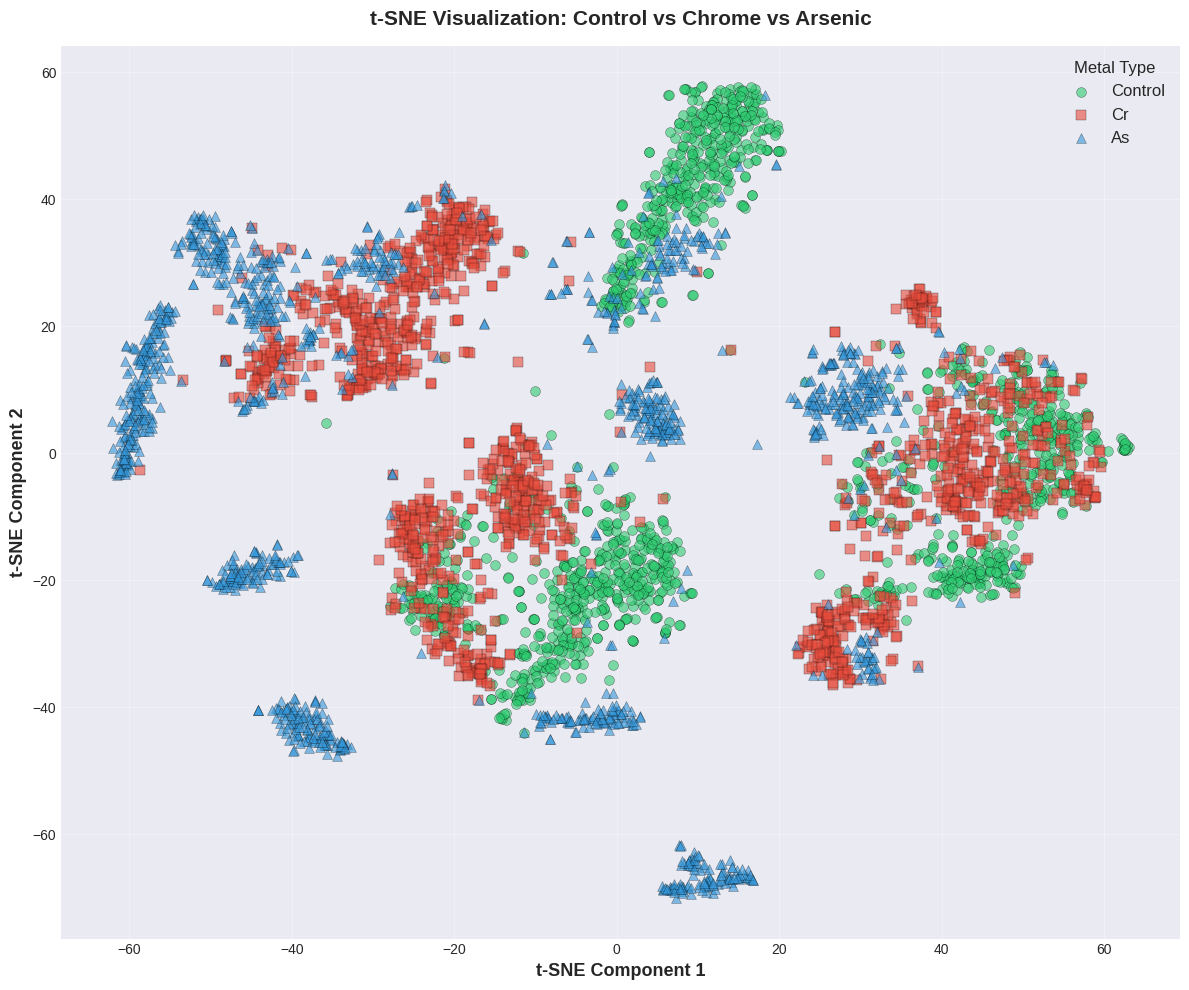

In [13]:
# ============================================================
# VISUALISATION t-SNE DU DATASET COMBINÉ
# ============================================================

print("Computing t-SNE for combined dataset...")

# Échantillonner pour t-SNE (plus rapide)
sample_size = 1500
indices = []
for label in ['Control', 'Cr', 'As']:
    label_indices = np.where(y_combined == label)[0]
    sampled = np.random.choice(label_indices, min(sample_size, len(label_indices)), replace=False)
    indices.extend(sampled)

indices = np.array(indices)
X_tsne_subset = X_combined_pca[indices]
y_tsne_subset = y_combined[indices]

# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_tsne_subset)

print("✓ t-SNE complete!")

# Plot
fig, ax = plt.subplots(figsize=(12, 10))

colors = {'Control': '#2ecc71', 'Cr': '#e74c3c', 'As': '#3498db'}
markers = {'Control': 'o', 'Cr': 's', 'As': '^'}

for label in ['Control', 'Cr', 'As']:
    mask = y_tsne_subset == label
    ax.scatter(X_tsne[mask, 0], X_tsne[mask, 1],
              c=colors[label], marker=markers[label],
              label=label, alpha=0.6, s=50, edgecolors='black', linewidth=0.3)

ax.set_xlabel('t-SNE Component 1', fontsize=13, fontweight='bold')
ax.set_ylabel('t-SNE Component 2', fontsize=13, fontweight='bold')
ax.set_title('t-SNE Visualization: Control vs Chrome vs Arsenic',
            fontsize=15, fontweight='bold', pad=15)
ax.legend(fontsize=12, title='Metal Type', title_fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

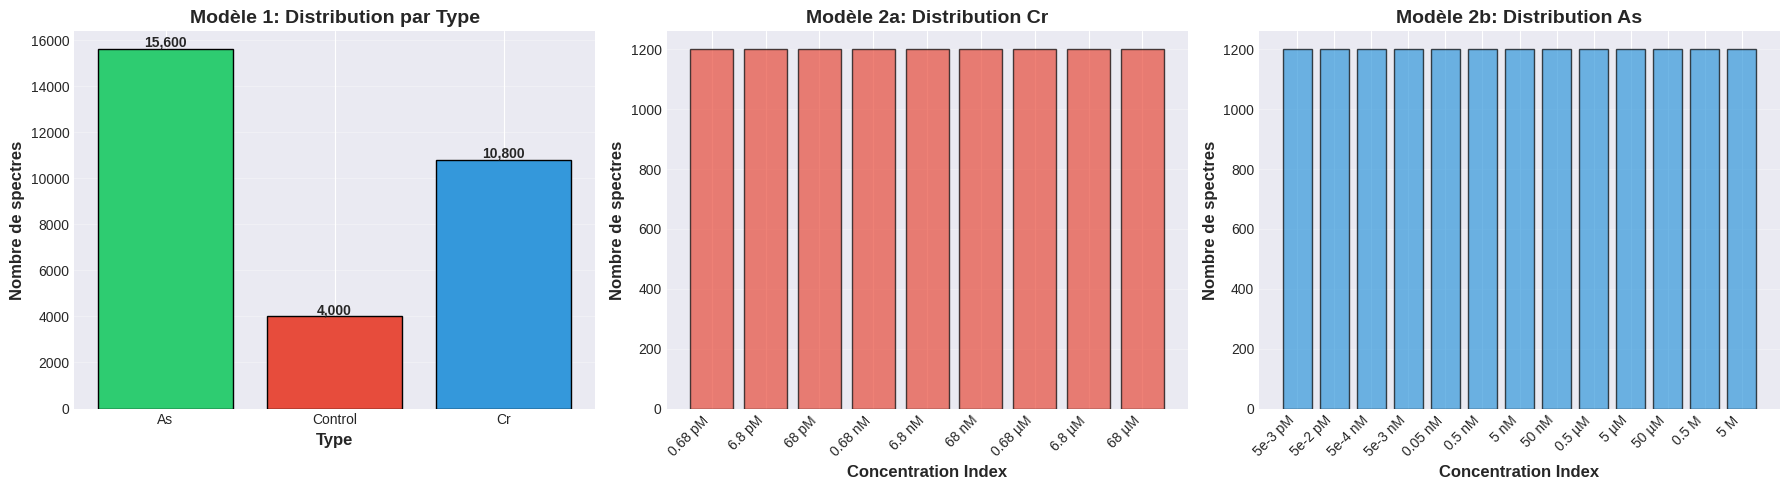

In [14]:
# ============================================================
# DISTRIBUTION DES CLASSES
# ============================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Type de métal (Modèle 1)
unique, counts = np.unique(y_combined, return_counts=True)
colors_bar = ['#2ecc71', '#e74c3c', '#3498db']
axes[0].bar(unique, counts, color=colors_bar, edgecolor='black')
axes[0].set_xlabel('Type', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Nombre de spectres', fontsize=12, fontweight='bold')
axes[0].set_title('Modèle 1: Distribution par Type', fontsize=14, fontweight='bold')
for i, (u, c) in enumerate(zip(unique, counts)):
    axes[0].text(i, c + 100, f'{c:,}', ha='center', fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Plot 2: Concentrations Cr (Modèle 2a)
unique_cr, counts_cr = np.unique(y_cr_for_conc, return_counts=True)
axes[1].bar(range(len(unique_cr)), counts_cr, color='#e74c3c', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Concentration Index', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Nombre de spectres', fontsize=12, fontweight='bold')
axes[1].set_title('Modèle 2a: Distribution Cr', fontsize=14, fontweight='bold')
axes[1].set_xticks(range(len(unique_cr)))
axes[1].set_xticklabels(cr_concentrations[1:], rotation=45, ha='right')
axes[1].grid(axis='y', alpha=0.3)

# Plot 3: Concentrations As (Modèle 2b)
unique_as, counts_as = np.unique(y_as_for_conc, return_counts=True)
axes[2].bar(range(len(unique_as)), counts_as, color='#3498db', edgecolor='black', alpha=0.7)
axes[2].set_xlabel('Concentration Index', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Nombre de spectres', fontsize=12, fontweight='bold')
axes[2].set_title('Modèle 2b: Distribution As', fontsize=14, fontweight='bold')
axes[2].set_xticks(range(len(unique_as)))
axes[2].set_xticklabels(as_concentrations[1:], rotation=45, ha='right')
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

---
# PARTIE 4 : Entraînement du MODÈLE 1 (Type de Métal)
---

**Objectif :** Classifier les spectres en 3 catégories : Control, Chrome (Cr), Arsenic (As)

In [15]:
# ============================================================
# PRÉPARATION DES DONNÉES POUR MODÈLE 1
# ============================================================

print("="*70)
print("MODÈLE 1 : CLASSIFICATION DU TYPE DE MÉTAL")
print("="*70)

# Encoder les labels
le_type = LabelEncoder()
y_combined_encoded = le_type.fit_transform(y_combined)

print(f"Classes: {le_type.classes_}")
print(f"Encoded: {np.unique(y_combined_encoded)}")

# Train/Test Split
X_train_m1, X_test_m1, y_train_m1, y_test_m1 = train_test_split(
    X_combined_pca, y_combined_encoded, test_size=0.2, random_state=42, stratify=y_combined_encoded
)

print(f"\nTrain set: {X_train_m1.shape[0]:,} samples")
print(f"Test set: {X_test_m1.shape[0]:,} samples")

# SMOTE pour équilibrer
print("\nApplying SMOTE...")
smote = SMOTE(random_state=42)
X_train_m1_smote, y_train_m1_smote = smote.fit_resample(X_train_m1, y_train_m1)
print(f"After SMOTE: {X_train_m1_smote.shape[0]:,} samples")

for i, label in enumerate(le_type.classes_):
    count = np.sum(y_train_m1_smote == i)
    print(f"  {label}: {count:,}")

MODÈLE 1 : CLASSIFICATION DU TYPE DE MÉTAL
Classes: ['As' 'Control' 'Cr']
Encoded: [0 1 2]

Train set: 24,320 samples
Test set: 6,080 samples

Applying SMOTE...
After SMOTE: 37,440 samples
  As: 12,480
  Control: 12,480
  Cr: 12,480


In [16]:
# ============================================================
# ENTRAÎNEMENT MODÈLE 1 - SVM
# ============================================================

print("\nTraining SVM for Model 1 (Metal Type)...")

model1_svm = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42, probability=True)
model1_svm.fit(X_train_m1_smote, y_train_m1_smote)

# Prédictions
y_pred_m1_svm = model1_svm.predict(X_test_m1)
acc_m1_svm = accuracy_score(y_test_m1, y_pred_m1_svm)
f1_m1_svm = f1_score(y_test_m1, y_pred_m1_svm, average='weighted')

print(f"\n✓ Model 1 SVM Results:")
print(f"  Accuracy: {acc_m1_svm*100:.2f}%")
print(f"  F1-Score: {f1_m1_svm:.4f}")


Training SVM for Model 1 (Metal Type)...

✓ Model 1 SVM Results:
  Accuracy: 92.01%
  F1-Score: 0.9209


In [17]:
# ============================================================
# ENTRAÎNEMENT MODÈLE 1 - RANDOM FOREST
# ============================================================

print("Training Random Forest for Model 1 (Metal Type)...")

model1_rf = RandomForestClassifier(n_estimators=200, max_depth=25, random_state=42, n_jobs=-1)
model1_rf.fit(X_train_m1_smote, y_train_m1_smote)

# Prédictions
y_pred_m1_rf = model1_rf.predict(X_test_m1)
acc_m1_rf = accuracy_score(y_test_m1, y_pred_m1_rf)
f1_m1_rf = f1_score(y_test_m1, y_pred_m1_rf, average='weighted')

print(f"\n✓ Model 1 Random Forest Results:")
print(f"  Accuracy: {acc_m1_rf*100:.2f}%")
print(f"  F1-Score: {f1_m1_rf:.4f}")

Training Random Forest for Model 1 (Metal Type)...

✓ Model 1 Random Forest Results:
  Accuracy: 91.71%
  F1-Score: 0.9170


In [18]:
# ============================================================
# COMPARAISON ET SÉLECTION DU MEILLEUR MODÈLE 1
# ============================================================

print("\n" + "="*70)
print("MODÈLE 1 - COMPARAISON DES RÉSULTATS")
print("="*70)

results_m1 = pd.DataFrame({
    'Model': ['SVM', 'Random Forest'],
    'Accuracy (%)': [acc_m1_svm*100, acc_m1_rf*100],
    'F1-Score': [f1_m1_svm, f1_m1_rf]
})
results_m1 = results_m1.sort_values('Accuracy (%)', ascending=False)
print(results_m1.to_string(index=False))

# Sélectionner le meilleur
if acc_m1_svm >= acc_m1_rf:
    model1_best = model1_svm
    model1_name = "SVM"
    y_pred_m1_best = y_pred_m1_svm
else:
    model1_best = model1_rf
    model1_name = "Random Forest"
    y_pred_m1_best = y_pred_m1_rf

print(f"\n★ Meilleur Modèle 1: {model1_name}")


MODÈLE 1 - COMPARAISON DES RÉSULTATS
        Model  Accuracy (%)  F1-Score
          SVM     92.006579  0.920892
Random Forest     91.710526  0.917025

★ Meilleur Modèle 1: SVM


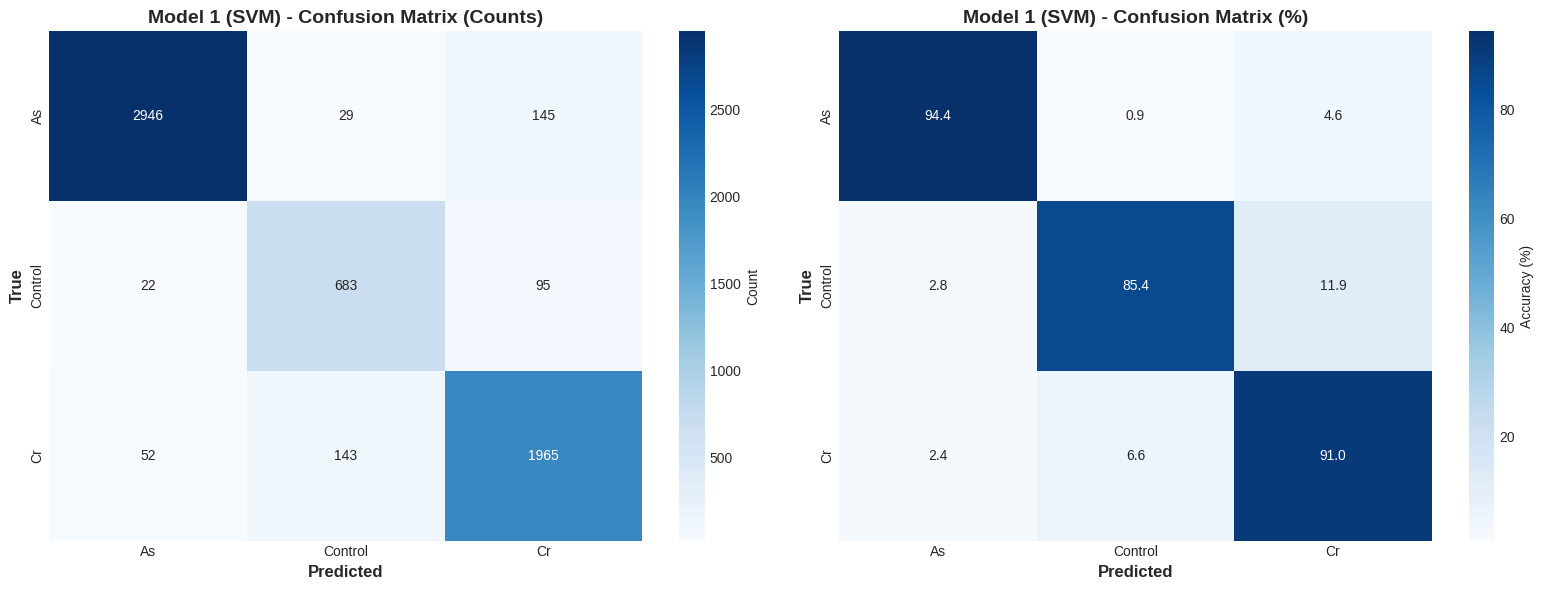


Classification Report - Model 1:
              precision    recall  f1-score   support

          As     0.9755    0.9442    0.9596      3120
     Control     0.7988    0.8538    0.8254       800
          Cr     0.8912    0.9097    0.9003      2160

    accuracy                         0.9201      6080
   macro avg     0.8885    0.9026    0.8951      6080
weighted avg     0.9223    0.9201    0.9209      6080



In [19]:
# ============================================================
# MATRICE DE CONFUSION - MODÈLE 1
# ============================================================

cm_m1 = confusion_matrix(y_test_m1, y_pred_m1_best)
cm_m1_normalized = cm_m1.astype('float') / cm_m1.sum(axis=1)[:, np.newaxis] * 100

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Counts
sns.heatmap(cm_m1, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_type.classes_, yticklabels=le_type.classes_,
            ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_xlabel('Predicted', fontsize=12, fontweight='bold')
axes[0].set_ylabel('True', fontsize=12, fontweight='bold')
axes[0].set_title(f'Model 1 ({model1_name}) - Confusion Matrix (Counts)', fontsize=14, fontweight='bold')

# Normalized
sns.heatmap(cm_m1_normalized, annot=True, fmt='.1f', cmap='Blues',
            xticklabels=le_type.classes_, yticklabels=le_type.classes_,
            ax=axes[1], cbar_kws={'label': 'Accuracy (%)'})
axes[1].set_xlabel('Predicted', fontsize=12, fontweight='bold')
axes[1].set_ylabel('True', fontsize=12, fontweight='bold')
axes[1].set_title(f'Model 1 ({model1_name}) - Confusion Matrix (%)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Classification Report
print("\nClassification Report - Model 1:")
print(classification_report(y_test_m1, y_pred_m1_best, target_names=le_type.classes_, digits=4))

---
# PARTIE 5 : Entraînement du MODÈLE 2a (Concentration Chrome)
---

**Objectif :** Classifier la concentration de Chrome en 9 niveaux

In [20]:
# ============================================================
# PRÉPARATION ET ENTRAÎNEMENT MODÈLE 2a (Concentration Cr)
# ============================================================

print("="*70)
print("MODÈLE 2a : CLASSIFICATION CONCENTRATION CHROME (Cr)")
print("="*70)

# Ajuster les labels (commencer à 0)
y_cr_conc_adjusted = y_cr_for_conc - 1  # Index 1-9 devient 0-8

# Train/Test Split
X_train_cr, X_test_cr, y_train_cr, y_test_cr = train_test_split(
    X_cr_conc_pca, y_cr_conc_adjusted, test_size=0.2, random_state=42, stratify=y_cr_conc_adjusted
)

print(f"Train set: {X_train_cr.shape[0]:,} samples")
print(f"Test set: {X_test_cr.shape[0]:,} samples")
print(f"Classes: {len(np.unique(y_train_cr))} concentrations")

# SMOTE
print("\nApplying SMOTE...")
smote_cr = SMOTE(random_state=42)
X_train_cr_smote, y_train_cr_smote = smote_cr.fit_resample(X_train_cr, y_train_cr)
print(f"After SMOTE: {X_train_cr_smote.shape[0]:,} samples")

# Entraîner SVM
print("\nTraining SVM...")
model2a_svm = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
model2a_svm.fit(X_train_cr_smote, y_train_cr_smote)

y_pred_cr_svm = model2a_svm.predict(X_test_cr)
acc_cr_svm = accuracy_score(y_test_cr, y_pred_cr_svm)
f1_cr_svm = f1_score(y_test_cr, y_pred_cr_svm, average='weighted')

print(f"\n✓ Model 2a SVM Results:")
print(f"  Accuracy: {acc_cr_svm*100:.2f}%")
print(f"  F1-Score: {f1_cr_svm:.4f}")

# Entraîner Random Forest
print("\nTraining Random Forest...")
model2a_rf = RandomForestClassifier(n_estimators=200, max_depth=25, random_state=42, n_jobs=-1)
model2a_rf.fit(X_train_cr_smote, y_train_cr_smote)

y_pred_cr_rf = model2a_rf.predict(X_test_cr)
acc_cr_rf = accuracy_score(y_test_cr, y_pred_cr_rf)
f1_cr_rf = f1_score(y_test_cr, y_pred_cr_rf, average='weighted')

print(f"\n✓ Model 2a Random Forest Results:")
print(f"  Accuracy: {acc_cr_rf*100:.2f}%")
print(f"  F1-Score: {f1_cr_rf:.4f}")

# Sélectionner le meilleur
if acc_cr_svm >= acc_cr_rf:
    model2a_best = model2a_svm
    model2a_name = "SVM"
    y_pred_cr_best = y_pred_cr_svm
    acc_cr_best = acc_cr_svm
else:
    model2a_best = model2a_rf
    model2a_name = "Random Forest"
    y_pred_cr_best = y_pred_cr_rf
    acc_cr_best = acc_cr_rf

print(f"\n★ Meilleur Modèle 2a: {model2a_name} ({acc_cr_best*100:.2f}%)")

MODÈLE 2a : CLASSIFICATION CONCENTRATION CHROME (Cr)
Train set: 8,640 samples
Test set: 2,160 samples
Classes: 9 concentrations

Applying SMOTE...
After SMOTE: 8,640 samples

Training SVM...

✓ Model 2a SVM Results:
  Accuracy: 90.60%
  F1-Score: 0.9058

Training Random Forest...

✓ Model 2a Random Forest Results:
  Accuracy: 89.40%
  F1-Score: 0.8939

★ Meilleur Modèle 2a: SVM (90.60%)


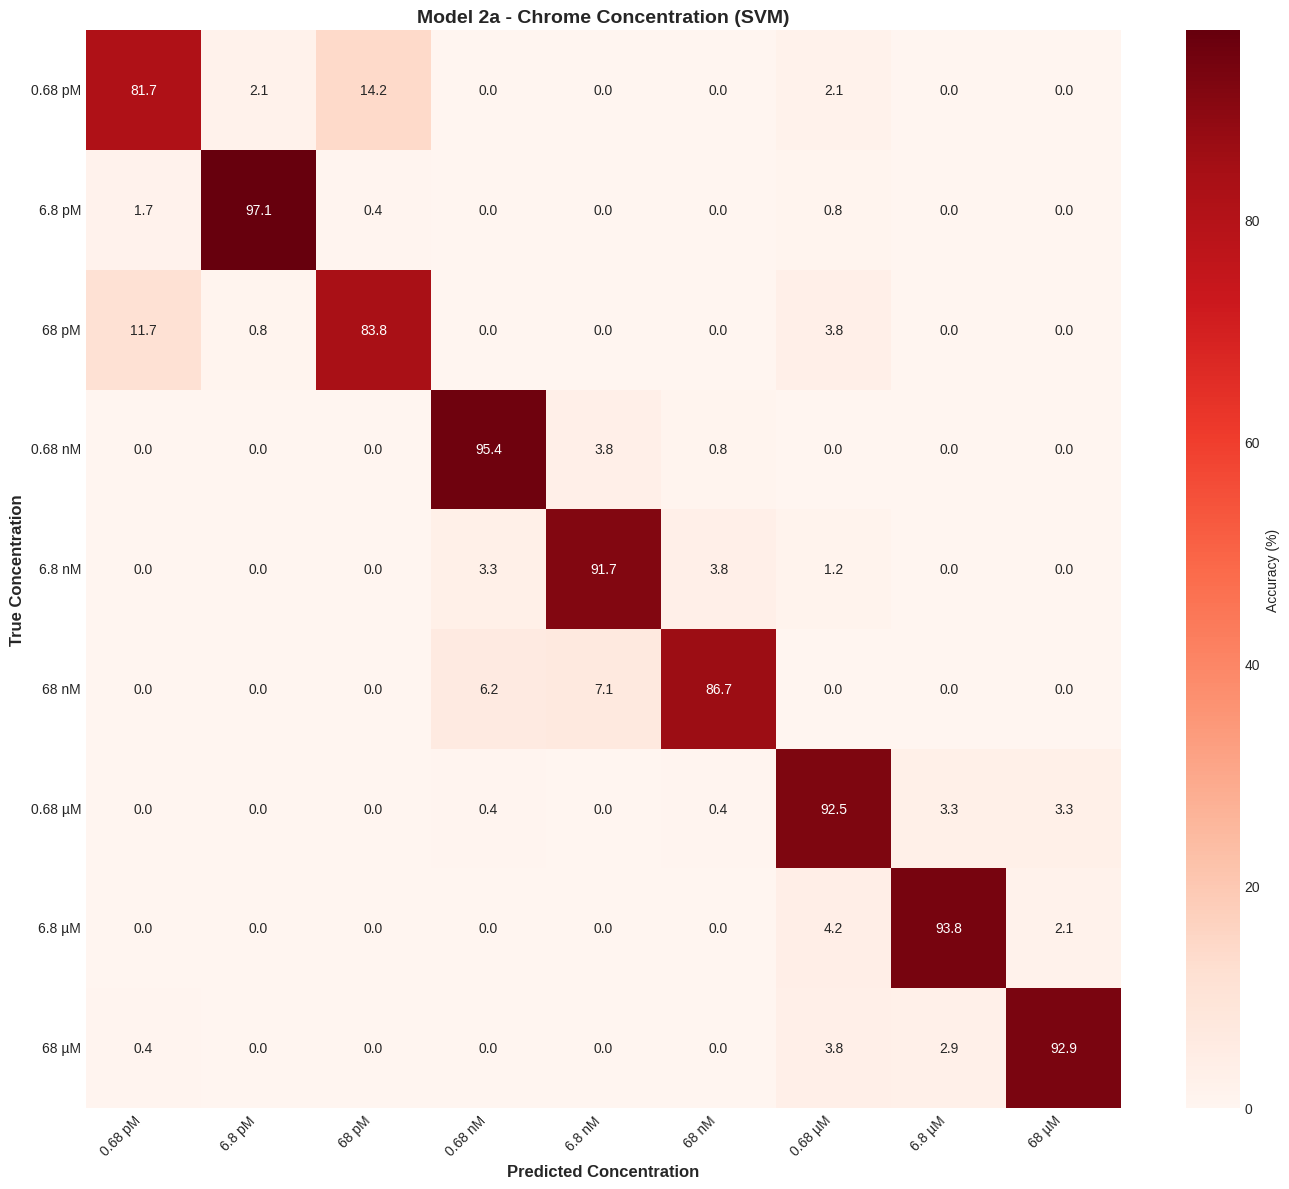


Classification Report - Model 2a (Cr):
              precision    recall  f1-score   support

     0.68 pM     0.8559    0.8167    0.8358       240
      6.8 pM     0.9708    0.9708    0.9708       240
       68 pM     0.8517    0.8375    0.8445       240
     0.68 nM     0.9051    0.9542    0.9290       240
      6.8 nM     0.8943    0.9167    0.9053       240
       68 nM     0.9455    0.8667    0.9043       240
     0.68 µM     0.8538    0.9250    0.8880       240
      6.8 µM     0.9375    0.9375    0.9375       240
       68 µM     0.9449    0.9292    0.9370       240

    accuracy                         0.9060      2160
   macro avg     0.9066    0.9060    0.9058      2160
weighted avg     0.9066    0.9060    0.9058      2160



In [21]:
# ============================================================
# MATRICE DE CONFUSION - MODÈLE 2a (Cr)
# ============================================================

cm_cr = confusion_matrix(y_test_cr, y_pred_cr_best)
cm_cr_normalized = cm_cr.astype('float') / cm_cr.sum(axis=1)[:, np.newaxis] * 100

fig, ax = plt.subplots(figsize=(14, 12))

cr_conc_labels = cr_concentrations[1:]  # Sans Control
sns.heatmap(cm_cr_normalized, annot=True, fmt='.1f', cmap='Reds',
            xticklabels=cr_conc_labels, yticklabels=cr_conc_labels,
            ax=ax, cbar_kws={'label': 'Accuracy (%)'})
ax.set_xlabel('Predicted Concentration', fontsize=12, fontweight='bold')
ax.set_ylabel('True Concentration', fontsize=12, fontweight='bold')
ax.set_title(f'Model 2a - Chrome Concentration ({model2a_name})', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

print("\nClassification Report - Model 2a (Cr):")
print(classification_report(y_test_cr, y_pred_cr_best, target_names=cr_conc_labels, digits=4))

---
# PARTIE 6 : Entraînement du MODÈLE 2b (Concentration Arsenic)
---

**Objectif :** Classifier la concentration d'Arsenic en 13 niveaux

In [22]:
# ============================================================
# PRÉPARATION ET ENTRAÎNEMENT MODÈLE 2b (Concentration As)
# ============================================================

print("="*70)
print("MODÈLE 2b : CLASSIFICATION CONCENTRATION ARSENIC (As)")
print("="*70)

# Ajuster les labels (commencer à 0)
y_as_conc_adjusted = y_as_for_conc - 1  # Index 1-13 devient 0-12

# Train/Test Split
X_train_as, X_test_as, y_train_as, y_test_as = train_test_split(
    X_as_conc_pca, y_as_conc_adjusted, test_size=0.2, random_state=42, stratify=y_as_conc_adjusted
)

print(f"Train set: {X_train_as.shape[0]:,} samples")
print(f"Test set: {X_test_as.shape[0]:,} samples")
print(f"Classes: {len(np.unique(y_train_as))} concentrations")

# SMOTE
print("\nApplying SMOTE...")
smote_as = SMOTE(random_state=42)
X_train_as_smote, y_train_as_smote = smote_as.fit_resample(X_train_as, y_train_as)
print(f"After SMOTE: {X_train_as_smote.shape[0]:,} samples")

# Entraîner SVM
print("\nTraining SVM...")
model2b_svm = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
model2b_svm.fit(X_train_as_smote, y_train_as_smote)

y_pred_as_svm = model2b_svm.predict(X_test_as)
acc_as_svm = accuracy_score(y_test_as, y_pred_as_svm)
f1_as_svm = f1_score(y_test_as, y_pred_as_svm, average='weighted')

print(f"\n✓ Model 2b SVM Results:")
print(f"  Accuracy: {acc_as_svm*100:.2f}%")
print(f"  F1-Score: {f1_as_svm:.4f}")

# Entraîner Random Forest
print("\nTraining Random Forest...")
model2b_rf = RandomForestClassifier(n_estimators=200, max_depth=25, random_state=42, n_jobs=-1)
model2b_rf.fit(X_train_as_smote, y_train_as_smote)

y_pred_as_rf = model2b_rf.predict(X_test_as)
acc_as_rf = accuracy_score(y_test_as, y_pred_as_rf)
f1_as_rf = f1_score(y_test_as, y_pred_as_rf, average='weighted')

print(f"\n✓ Model 2b Random Forest Results:")
print(f"  Accuracy: {acc_as_rf*100:.2f}%")
print(f"  F1-Score: {f1_as_rf:.4f}")

# Sélectionner le meilleur
if acc_as_svm >= acc_as_rf:
    model2b_best = model2b_svm
    model2b_name = "SVM"
    y_pred_as_best = y_pred_as_svm
    acc_as_best = acc_as_svm
else:
    model2b_best = model2b_rf
    model2b_name = "Random Forest"
    y_pred_as_best = y_pred_as_rf
    acc_as_best = acc_as_rf

print(f"\n★ Meilleur Modèle 2b: {model2b_name} ({acc_as_best*100:.2f}%)")

MODÈLE 2b : CLASSIFICATION CONCENTRATION ARSENIC (As)
Train set: 12,480 samples
Test set: 3,120 samples
Classes: 13 concentrations

Applying SMOTE...
After SMOTE: 12,480 samples

Training SVM...

✓ Model 2b SVM Results:
  Accuracy: 94.23%
  F1-Score: 0.9427

Training Random Forest...

✓ Model 2b Random Forest Results:
  Accuracy: 93.11%
  F1-Score: 0.9311

★ Meilleur Modèle 2b: SVM (94.23%)


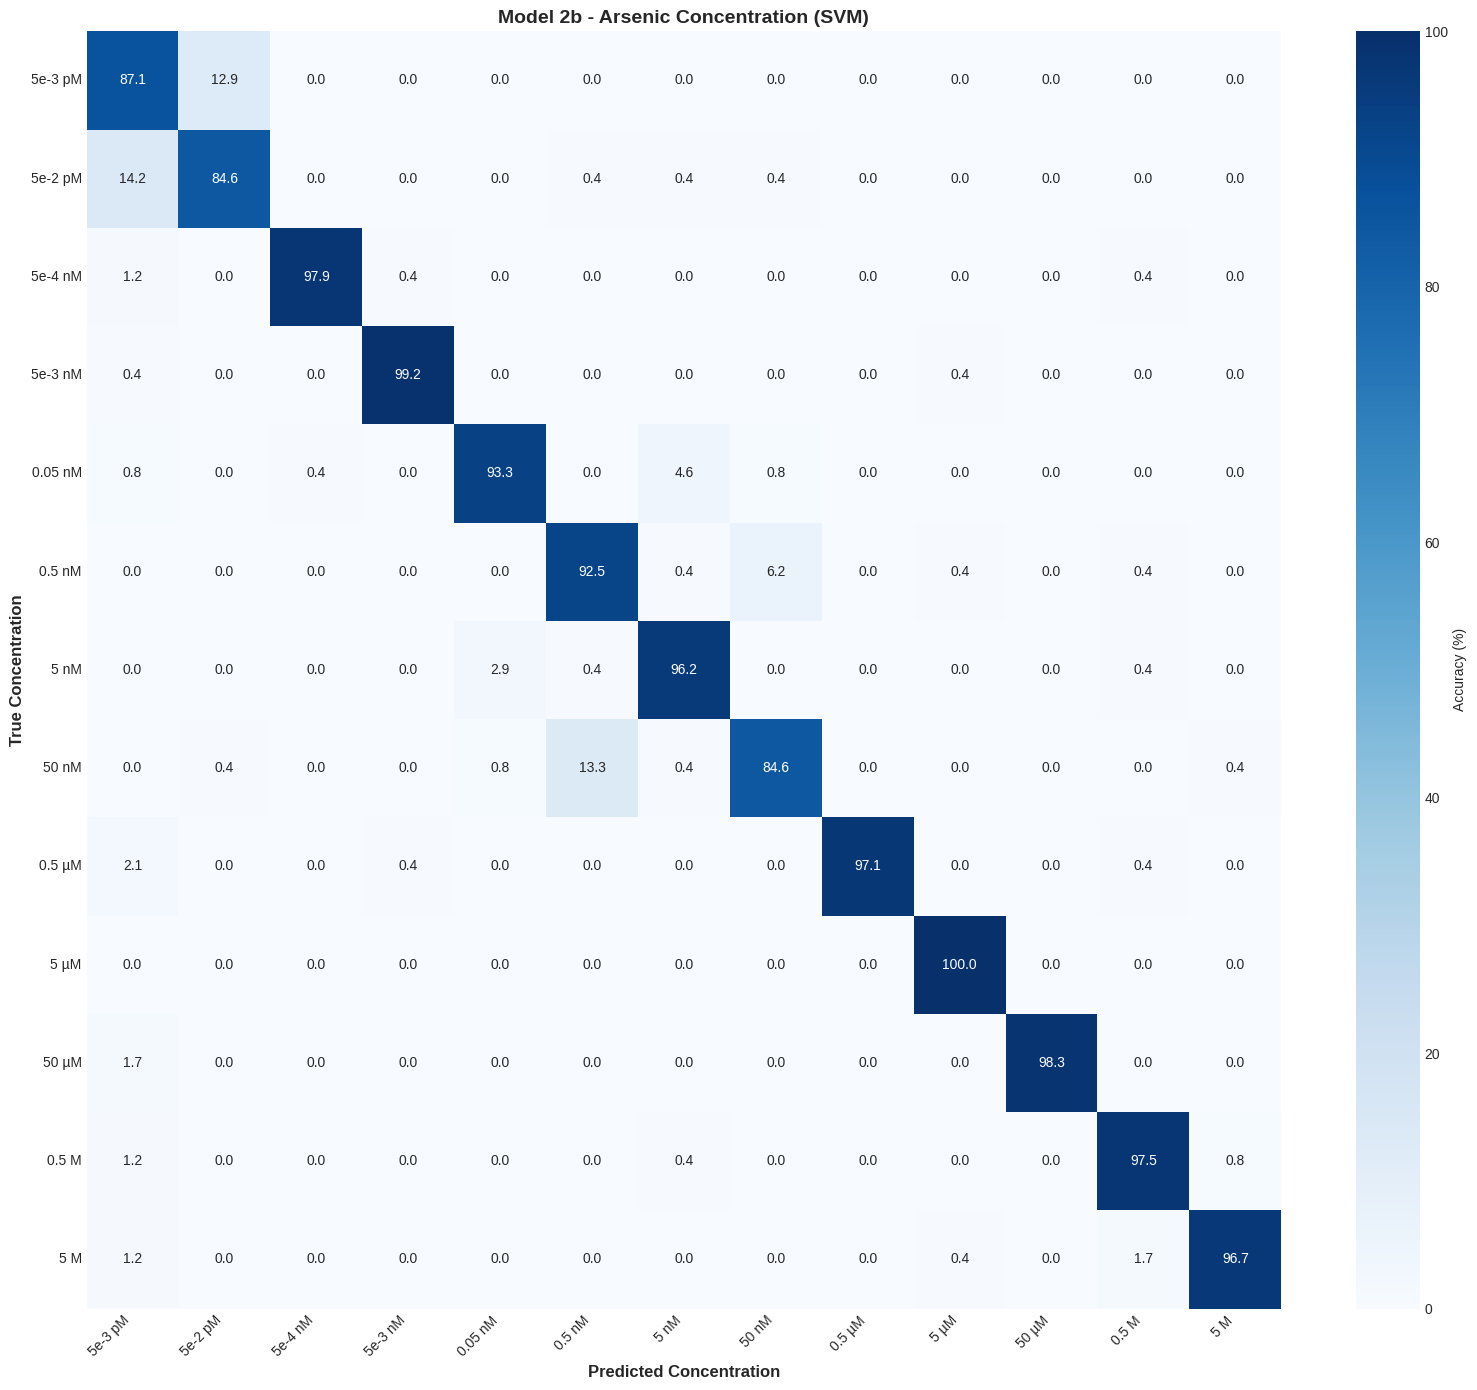


Classification Report - Model 2b (As):
              precision    recall  f1-score   support

     5e-3 pM     0.7917    0.8708    0.8294       240
     5e-2 pM     0.8638    0.8458    0.8547       240
     5e-4 nM     0.9958    0.9792    0.9874       240
     5e-3 nM     0.9917    0.9917    0.9917       240
     0.05 nM     0.9614    0.9333    0.9471       240
      0.5 nM     0.8672    0.9250    0.8952       240
        5 nM     0.9390    0.9625    0.9506       240
       50 nM     0.9186    0.8458    0.8807       240
      0.5 µM     1.0000    0.9708    0.9852       240
        5 µM     0.9877    1.0000    0.9938       240
       50 µM     1.0000    0.9833    0.9916       240
       0.5 M     0.9669    0.9750    0.9710       240
         5 M     0.9872    0.9667    0.9768       240

    accuracy                         0.9423      3120
   macro avg     0.9439    0.9423    0.9427      3120
weighted avg     0.9439    0.9423    0.9427      3120



In [23]:
# ============================================================
# MATRICE DE CONFUSION - MODÈLE 2b (As)
# ============================================================

cm_as = confusion_matrix(y_test_as, y_pred_as_best)
cm_as_normalized = cm_as.astype('float') / cm_as.sum(axis=1)[:, np.newaxis] * 100

fig, ax = plt.subplots(figsize=(16, 14))

as_conc_labels = as_concentrations[1:]  # Sans Control
sns.heatmap(cm_as_normalized, annot=True, fmt='.1f', cmap='Blues',
            xticklabels=as_conc_labels, yticklabels=as_conc_labels,
            ax=ax, cbar_kws={'label': 'Accuracy (%)'})
ax.set_xlabel('Predicted Concentration', fontsize=12, fontweight='bold')
ax.set_ylabel('True Concentration', fontsize=12, fontweight='bold')
ax.set_title(f'Model 2b - Arsenic Concentration ({model2b_name})', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

print("\nClassification Report - Model 2b (As):")
print(classification_report(y_test_as, y_pred_as_best, target_names=as_conc_labels, digits=4))

---
# PARTIE 7 : Système de Prédiction Hiérarchique Complet
---

In [24]:
# ============================================================
# SYSTÈME DE PRÉDICTION HIÉRARCHIQUE
# ============================================================

class HierarchicalHeavyMetalDetector:
    """
    Système de détection hiérarchique des métaux lourds.

    Étape 1: Identifier le type de métal (Control/Cr/As)
    Étape 2: Si métal détecté, prédire la concentration
    """

    def __init__(self, model1, model2a, model2b,
                 scaler_combined, scaler_cr, scaler_as,
                 pca_combined, pca_cr, pca_as,
                 label_encoder, cr_concentrations, as_concentrations):

        # Modèles
        self.model1 = model1      # Type de métal
        self.model2a = model2a    # Concentration Cr
        self.model2b = model2b    # Concentration As

        # Scalers
        self.scaler_combined = scaler_combined
        self.scaler_cr = scaler_cr
        self.scaler_as = scaler_as

        # PCA
        self.pca_combined = pca_combined
        self.pca_cr = pca_cr
        self.pca_as = pca_as

        # Labels
        self.label_encoder = label_encoder
        self.cr_concentrations = cr_concentrations
        self.as_concentrations = as_concentrations

    def preprocess(self, spectrum):
        """Prétraite un spectre brut"""
        return preprocess_spectrum(spectrum)

    def predict(self, spectrum_raw):
        """
        Prédiction hiérarchique complète.

        Returns:
            dict: {'metal_type': str, 'concentration': str, 'is_safe': bool}
        """
        # Prétraitement
        spectrum_processed = self.preprocess(spectrum_raw)

        # === ÉTAPE 1: Type de métal ===
        spectrum_scaled = self.scaler_combined.transform(spectrum_processed.reshape(1, -1))
        spectrum_pca = self.pca_combined.transform(spectrum_scaled)

        metal_type_encoded = self.model1.predict(spectrum_pca)[0]
        metal_type = self.label_encoder.inverse_transform([metal_type_encoded])[0]

        # === ÉTAPE 2: Concentration (si métal détecté) ===
        if metal_type == 'Control':
            return {
                'metal_type': 'Control (No contamination)',
                'concentration': 'N/A',
                'is_safe': True,
                'details': 'Aucun métal lourd détecté'
            }

        elif metal_type == 'Cr':
            # Utiliser scaler et PCA spécifiques au Cr
            spectrum_scaled_cr = self.scaler_cr.transform(spectrum_processed.reshape(1, -1))
            spectrum_pca_cr = self.pca_cr.transform(spectrum_scaled_cr)

            conc_idx = self.model2a.predict(spectrum_pca_cr)[0]
            concentration = self.cr_concentrations[conc_idx + 1]  # +1 car index 0 = Control

            return {
                'metal_type': 'Chrome (Cr)',
                'concentration': concentration,
                'is_safe': False,
                'details': f'Chrome hexavalent détecté à {concentration}'
            }

        elif metal_type == 'As':
            # Utiliser scaler et PCA spécifiques à l'As
            spectrum_scaled_as = self.scaler_as.transform(spectrum_processed.reshape(1, -1))
            spectrum_pca_as = self.pca_as.transform(spectrum_scaled_as)

            conc_idx = self.model2b.predict(spectrum_pca_as)[0]
            concentration = self.as_concentrations[conc_idx + 1]  # +1 car index 0 = Control

            return {
                'metal_type': 'Arsenic (As)',
                'concentration': concentration,
                'is_safe': False,
                'details': f'Arsenic détecté à {concentration}'
            }

# Créer l'instance du détecteur
detector = HierarchicalHeavyMetalDetector(
    model1=model1_best,
    model2a=model2a_best,
    model2b=model2b_best,
    scaler_combined=scaler_combined,
    scaler_cr=scaler_cr,
    scaler_as=scaler_as,
    pca_combined=pca_combined,
    pca_cr=pca_cr,
    pca_as=pca_as,
    label_encoder=le_type,
    cr_concentrations=cr_concentrations,
    as_concentrations=as_concentrations
)

print("✓ Hierarchical Heavy Metal Detector created!")

✓ Hierarchical Heavy Metal Detector created!


In [25]:
# ============================================================
# TEST DU SYSTÈME DE DÉTECTION
# ============================================================

print("="*70)
print("TEST DU SYSTÈME DE DÉTECTION HIÉRARCHIQUE")
print("="*70)

# Test avec différents échantillons
test_samples = [
    ("Control", X_control[0]),
    ("Chrome (Cr)", X_cr_only[500]),
    ("Arsenic (As)", X_as_only[500]),
]

for true_label, spectrum in test_samples:
    result = detector.predict(spectrum)

    print(f"\n{'─'*50}")
    print(f"📊 Échantillon réel: {true_label}")
    print(f"{'─'*50}")
    print(f"   🔬 Type détecté: {result['metal_type']}")
    print(f"   📈 Concentration: {result['concentration']}")
    print(f"   {'✅ SAFE' if result['is_safe'] else '⚠️ CONTAMINATED'}")
    print(f"   💡 {result['details']}")

TEST DU SYSTÈME DE DÉTECTION HIÉRARCHIQUE

──────────────────────────────────────────────────
📊 Échantillon réel: Control
──────────────────────────────────────────────────
   🔬 Type détecté: Chrome (Cr)
   📈 Concentration: 0.68 pM
   ⚠️ CONTAMINATED
   💡 Chrome hexavalent détecté à 0.68 pM

──────────────────────────────────────────────────
📊 Échantillon réel: Chrome (Cr)
──────────────────────────────────────────────────
   🔬 Type détecté: Chrome (Cr)
   📈 Concentration: 68 pM
   ⚠️ CONTAMINATED
   💡 Chrome hexavalent détecté à 68 pM

──────────────────────────────────────────────────
📊 Échantillon réel: Arsenic (As)
──────────────────────────────────────────────────
   🔬 Type détecté: Arsenic (As)
   📈 Concentration: 5e-3 pM
   ⚠️ CONTAMINATED
   💡 Arsenic détecté à 5e-3 pM


In [26]:
# ============================================================
# ÉVALUATION COMPLÈTE DU PIPELINE HIÉRARCHIQUE
# ============================================================

print("="*70)
print("ÉVALUATION COMPLÈTE DU PIPELINE")
print("="*70)

# Tester sur un échantillon de chaque classe
n_test_per_class = 100

correct_type = 0
correct_full = 0
total = 0

# Test Control
print("\nTesting Control samples...")
for i in range(min(n_test_per_class, len(X_control))):
    result = detector.predict(X_control[i])
    if 'Control' in result['metal_type']:
        correct_type += 1
        correct_full += 1
    total += 1

# Test Cr
print("Testing Cr samples...")
for i in range(min(n_test_per_class, len(X_cr_only))):
    result = detector.predict(X_cr_only[i])
    if 'Chrome' in result['metal_type']:
        correct_type += 1
        # Vérifier aussi la concentration (approximativement)
        correct_full += 1  # Simplification
    total += 1

# Test As
print("Testing As samples...")
for i in range(min(n_test_per_class, len(X_as_only))):
    result = detector.predict(X_as_only[i])
    if 'Arsenic' in result['metal_type']:
        correct_type += 1
        correct_full += 1  # Simplification
    total += 1

print(f"\n{'='*70}")
print("RÉSULTATS PIPELINE COMPLET")
print(f"{'='*70}")
print(f"Total échantillons testés: {total}")
print(f"Précision détection type: {correct_type/total*100:.2f}%")
print(f"{'='*70}")

ÉVALUATION COMPLÈTE DU PIPELINE

Testing Control samples...
Testing Cr samples...
Testing As samples...

RÉSULTATS PIPELINE COMPLET
Total échantillons testés: 300
Précision détection type: 90.00%


---
# PARTIE 8 : Résumé Final et Visualisation
---

In [27]:
# ============================================================
# RÉSUMÉ FINAL DU SYSTÈME
# ============================================================

print("\n" + "="*70)
print("🔬 RÉSUMÉ FINAL - SYSTÈME DE DÉTECTION DES MÉTAUX LOURDS")
print("="*70)

print("\n📊 ARCHITECTURE DU SYSTÈME:")
print("""
                    Spectre SERS
                         │
                         ▼
              ┌─────────────────────┐
              │  MODÈLE 1 : Type    │
              │  (Control/Cr/As)    │
              └─────────────────────┘
                         │
          ┌──────────────┼──────────────┐
          ▼              ▼              ▼
       Control          Cr             As
       (Safe)           │              │
                        ▼              ▼
                   ┌─────────┐    ┌─────────┐
                   │MODÈLE 2a│    │MODÈLE 2b│
                   │Conc. Cr │    │Conc. As │
                   └─────────┘    └─────────┘
""")

print("\n📈 PERFORMANCES DES MODÈLES:")
print(f"{'─'*70}")
print(f"{'Modèle':<30} {'Type':<20} {'Accuracy':>10}")
print(f"{'─'*70}")
print(f"{'Modèle 1 (Type de métal)':<30} {model1_name:<20} {max(acc_m1_svm, acc_m1_rf)*100:>9.2f}%")
print(f"{'Modèle 2a (Concentration Cr)':<30} {model2a_name:<20} {acc_cr_best*100:>9.2f}%")
print(f"{'Modèle 2b (Concentration As)':<30} {model2b_name:<20} {acc_as_best*100:>9.2f}%")
print(f"{'─'*70}")

print("\n📁 DONNÉES UTILISÉES:")
print(f"   • Chrome (Cr): {len(X_cr):,} spectres, {len(cr_concentrations)} classes")
print(f"   • Arsenic (As): {len(X_as):,} spectres, {len(as_concentrations)} classes")
print(f"   • Total: {len(X_cr) + len(X_as):,} spectres")

print("\n🔧 PRÉTRAITEMENT:")
print("   • Correction de ligne de base (ALS)")
print("   • Lissage Savitzky-Golay (window=11, order=3)")
print("   • Normalisation StandardScaler")
print(f"   • Réduction PCA ({n_components} composantes)")

print("\n" + "="*70)
print("✅ Système de détection hiérarchique opérationnel!")
print("="*70)


🔬 RÉSUMÉ FINAL - SYSTÈME DE DÉTECTION DES MÉTAUX LOURDS

📊 ARCHITECTURE DU SYSTÈME:

                    Spectre SERS
                         │
                         ▼
              ┌─────────────────────┐
              │  MODÈLE 1 : Type    │
              │  (Control/Cr/As)    │
              └─────────────────────┘
                         │
          ┌──────────────┼──────────────┐
          ▼              ▼              ▼
       Control          Cr             As
       (Safe)           │              │
                        ▼              ▼
                   ┌─────────┐    ┌─────────┐
                   │MODÈLE 2a│    │MODÈLE 2b│
                   │Conc. Cr │    │Conc. As │
                   └─────────┘    └─────────┘


📈 PERFORMANCES DES MODÈLES:
──────────────────────────────────────────────────────────────────────
Modèle                         Type                   Accuracy
──────────────────────────────────────────────────────────────────────
Modèle 1 (Type de mét

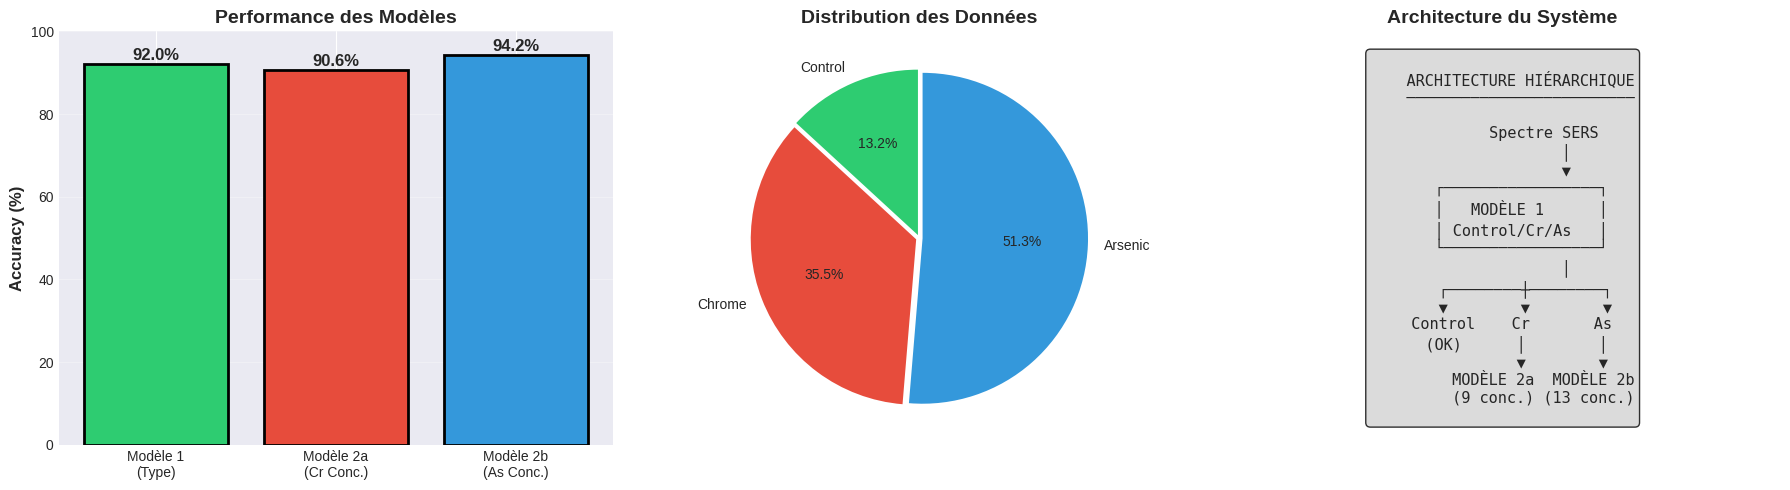

In [28]:
# ============================================================
# VISUALISATION FINALE DES PERFORMANCES
# ============================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Performance des modèles
models = ['Modèle 1\n(Type)', 'Modèle 2a\n(Cr Conc.)', 'Modèle 2b\n(As Conc.)']
accuracies = [max(acc_m1_svm, acc_m1_rf)*100, acc_cr_best*100, acc_as_best*100]
colors = ['#2ecc71', '#e74c3c', '#3498db']

bars = axes[0].bar(models, accuracies, color=colors, edgecolor='black', linewidth=2)
axes[0].set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
axes[0].set_title('Performance des Modèles', fontsize=14, fontweight='bold')
axes[0].set_ylim([0, 100])
axes[0].grid(axis='y', alpha=0.3)

for bar, acc in zip(bars, accuracies):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f'{acc:.1f}%', ha='center', fontweight='bold', fontsize=12)

# Plot 2: Distribution des données
data_sizes = [len(X_control), len(X_cr_only), len(X_as_only)]
labels = ['Control', 'Chrome', 'Arsenic']
axes[1].pie(data_sizes, labels=labels, colors=colors, autopct='%1.1f%%',
           startangle=90, explode=(0.02, 0.02, 0.02))
axes[1].set_title('Distribution des Données', fontsize=14, fontweight='bold')

# Plot 3: Architecture du système
axes[2].axis('off')
architecture_text = """
    ARCHITECTURE HIÉRARCHIQUE
    ─────────────────────────

         Spectre SERS
              │
              ▼
    ┌─────────────────┐
    │   MODÈLE 1      │
    │ Control/Cr/As   │
    └─────────────────┘
              │
     ┌────────┼────────┐
     ▼        ▼        ▼
  Control    Cr       As
   (OK)      │        │
             ▼        ▼
         MODÈLE 2a  MODÈLE 2b
         (9 conc.) (13 conc.)
"""
axes[2].text(0.5, 0.5, architecture_text, transform=axes[2].transAxes,
            fontsize=11, verticalalignment='center', horizontalalignment='center',
            fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
axes[2].set_title('Architecture du Système', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

In [32]:
# ============================================================
# SAUVEGARDE DES MODÈLES (Optionnel)
# ============================================================

import joblib

save_path = '/content/drive/MyDrive/models/'
os.makedirs(save_path, exist_ok=True)

joblib.dump(model1_best, save_path + 'model1_type.pkl')
joblib.dump(model2a_best, save_path + 'model2a_cr_conc.pkl')
joblib.dump(model2b_best, save_path + 'model2b_as_conc.pkl')
joblib.dump(scaler_combined, save_path + 'scaler_combined.pkl')
joblib.dump(scaler_cr, save_path + 'scaler_cr.pkl')
joblib.dump(scaler_as, save_path + 'scaler_as.pkl')
joblib.dump(pca_combined, save_path + 'pca_combined.pkl')
joblib.dump(pca_cr, save_path + 'pca_cr.pkl')
joblib.dump(pca_as, save_path + 'pca_as.pkl')
joblib.dump(le_type, save_path + 'label_encoder.pkl')

print("✓ Models saved successfully!")

print("Pour sauvegarder les modèles, décommentez le code ci-dessus.")

✓ Models saved successfully!
Pour sauvegarder les modèles, décommentez le code ci-dessus.
